In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

import matplotlib
matplotlib.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 10

import pandas as pd
import numpy as np
import os

In [3]:
start_date = pd.to_datetime('07/10/2024')
end_date = pd.to_datetime('07/29/2024')

In [4]:
bombus_listdir = [file for file in os.listdir('/home/misha/data/bee_cam/2024_image_processing/all_bombus') if file.endswith('.jpg')]
file_df = pd.DataFrame(bombus_listdir)
file_df[['pi', 'datetime']] = file_df[0].str.extract(r'^pi(\d+)_(\d{8}_\d{6})')
file_df['pi'] = file_df['pi'].astype(int)
file_df['datetime'] = pd.to_datetime(file_df['datetime'], format='%Y%m%d_%H%M%S')
file_df = file_df.rename(columns={0: 'filename'})
file_df = file_df.sort_values(by=['pi', 'datetime'], ascending=[True, True]).reset_index(drop=True)
file_df['date'] = pd.to_datetime(file_df['datetime'].dt.date)
file_df['time_diff'] = file_df.groupby(['pi', 'date'])['datetime'].diff().dt.total_seconds()

bombus_times = file_df.copy()
bombus_visits = file_df[(file_df['time_diff'] > 4) | (file_df['time_diff'].isna())]

hourly_bombus = bombus_visits.set_index('datetime').resample('D').size().reset_index(name='count')
hourly_bombus = hourly_bombus[hourly_bombus['count'] >0]

weather = pd.read_csv('csvs/hyslop_weather_data.csv').drop(index=0)
weather['Timestamps'] = pd.to_datetime(weather['Timestamps'], format='%m/%d/%Y %I:%M:%S %p')
weather = weather.drop(columns=[' °C Anemometer Temp', '° X-axis Level', '° Y-axis Level'])
weather.columns = ['datetime', 'air_temp', 'vapor_pres', 'atm_pres', 'vpd',  'wind_dir','wind_speed', 'gust_sp', 'ppfd']

hourly_weather = weather.set_index('datetime').resample('D').mean().reset_index()

bombus_visits_df = pd.merge_asof(
    bombus_visits.sort_values('datetime'),
    weather.sort_values('datetime'),
    left_on='datetime',
    right_on='datetime',
    direction='nearest'
).drop(columns='time_diff')

In [5]:
bombus_visits_df = bombus_visits_df[(bombus_visits_df['datetime'] >= start_date) & (bombus_visits_df['datetime'] <= end_date)]

In [6]:
merged_day = pd.merge_asof(
    hourly_bombus.sort_values('datetime'),
    hourly_weather.sort_values('datetime'),
    left_on='datetime',
    right_on='datetime',
    direction='nearest'
)

In [7]:
merged_times = pd.merge_asof(
    bombus_times.sort_values('datetime'),
    hourly_weather.sort_values('datetime'),
    left_on='datetime',
    right_on='datetime',
    direction='nearest'
).drop(columns='time_diff')

In [8]:
bombus_visits_df['air_temp'].min()

12.9

In [9]:
weather_daytime = weather[(weather['datetime'].dt.time >= pd.to_datetime('06:00:00').time()) & 
                  (weather['datetime'].dt.time <= pd.to_datetime('20:00:00').time())]

weather_daytime = weather_daytime[(weather_daytime['datetime'] >= start_date) & (weather_daytime['datetime'] <= end_date)]

In [10]:
weather_daytime['air_temp'].min()

9.0

Text(0.08, 0.5, 'Frequency')

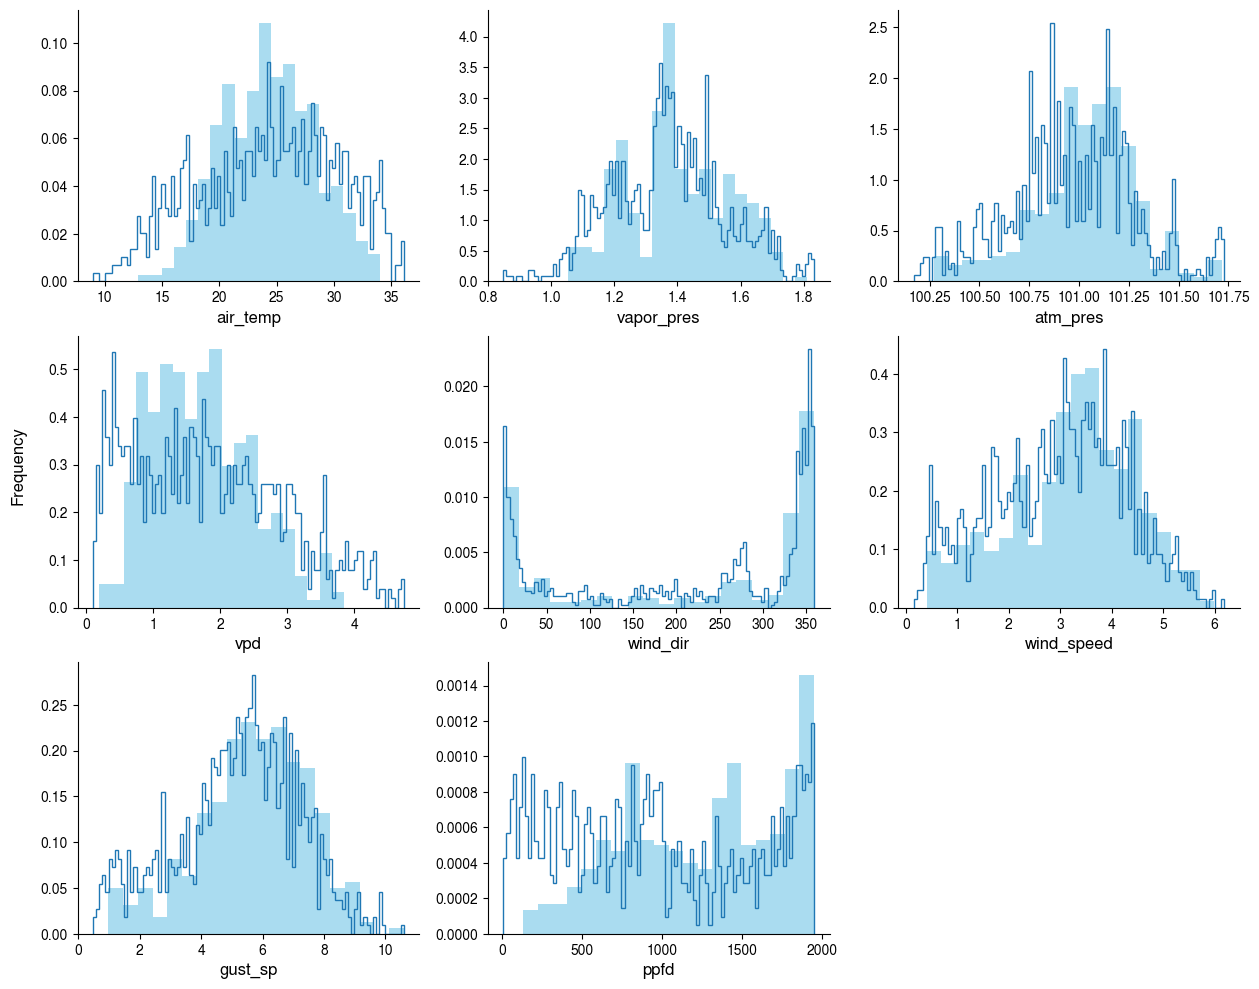

In [11]:
weather_columns = [col for col in bombus_visits_df.columns if col not in ['datetime', 'count', 'filename', 'pi', 'date', 'time_diff', 'Timestamps']]


n_cols = 3  
n_rows = -(-len(weather_columns) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
# plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(weather_columns):
    ax = axes.flat[i]
    ax.hist(bombus_visits_df[col], bins=20, color='skyblue', density=True, alpha=0.7)
    ax.hist(weather_daytime[col], bins= 100, density=True, histtype='step')
    # ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col, fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes.flat)):
    fig.delaxes(axes.flat[j])
fig.text(0.08, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=12)


In [12]:
bombus_visits_df['wind_speed'].max()

5.99

In [13]:
weather_daytime['vpd'].max()

4.74

In [14]:
weather_columns = [col for col in bombus_visits_df.columns if col in ['air_temp', 'wind_speed', 'vpd']]

In [15]:
weather_daytime['wind_speed'].max()

6.19

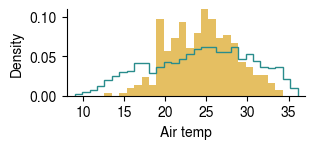

In [16]:
plt.figure(figsize=(3.25,1.6))
all_temps = np.concatenate([bombus_visits_df['air_temp'], weather_daytime['air_temp']])
bins = np.histogram_bin_edges(all_temps, bins=30) 

plt.hist(bombus_visits_df['air_temp'], bins=bins, color='goldenrod', density=True, alpha=0.7)
plt.hist(weather_daytime['air_temp'], bins= bins, color='#298c8c', density=True, histtype='step')

plt.ylim(0,0.11)
# plt.yticks([0,10,20,30,40,50], labels=['0', '10', '', '30', '', '50'], fontsize=9)
plt.ylabel('Density')

plt.xlim(8, 37)
xticks = [ 10, 15, 20, 25, 30, 35] 
# xlabels = [10, '', 20, '', 30, ''] 
plt.xticks(xticks, fontsize=10)
plt.xlabel('Air temp')

plt.tight_layout()

plt.savefig('figs/airtemp_wire.svg', format='svg', bbox_inches='tight')

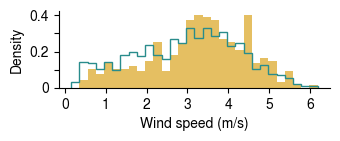

In [17]:
plt.figure(figsize=(3.5,1.5))
all_temps = np.concatenate([bombus_visits_df['wind_speed'], weather_daytime['wind_speed']])
bins = np.histogram_bin_edges(all_temps, bins=30) 

plt.hist(bombus_visits_df['wind_speed'], bins=bins, color='goldenrod', density=True, alpha=0.7)
plt.hist(weather_daytime['wind_speed'], bins= bins, color='#298c8c', density=True, histtype='step')

# plt.ylim(0,0.11)
plt.yticks([0,0.1,0.2,0.3,0.4],labels=['0', '', '0.2', '', '0.4', ],fontsize=10)
plt.ylabel('Density')

# plt.xlim(8, 37)
xticks = [ 0,1,2,3,4,5,6] 
# xlabels = [10, '', 20, '', 30, ''] 
plt.xticks(xticks, fontsize=10)
plt.xlabel('Wind speed (m/s)')

plt.tight_layout()

plt.savefig('figs/windspeed.svg', format='svg', bbox_inches='tight')

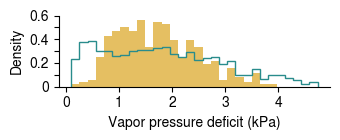

In [18]:
plt.figure(figsize=(3.5,1.5))
all_temps = np.concatenate([bombus_visits_df['vpd'], weather_daytime['vpd']])
bins = np.histogram_bin_edges(all_temps, bins=30) 

plt.hist(bombus_visits_df['vpd'], bins=bins, color='goldenrod', density=True, alpha=0.7)
plt.hist(weather_daytime['vpd'], bins= bins, color='#298c8c', density=True, histtype='step')

# plt.ylim(0,0.11)
# plt.yticks([0,10,20,30,40,50], labels=['0', '10', '', '30', '', '50'], fontsize=9)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6],labels=['0', '', '0.2', '', '0.4', '', '0.6'],fontsize=10)
plt.ylabel('Density')

# plt.xlim(8, 37)
# xticks = [ 10, 15, 20, 25, 30, 35] 
# xlabels = [10, '', 20, '', 30, ''] 
# plt.xticks(xticks, labels=xlabels, fontsize=9)
xticks = [ 0,1,2,3,4,5] 
plt.xlabel('Vapor pressure deficit (kPa)')

plt.tight_layout()

plt.savefig('figs/vaporpresdef.svg', format='svg', bbox_inches='tight')

air_temp, mean_val: 24.423493975903614, mean_daytime: 24.26999076638966
vpd, mean_val: 1.736265060240964, mean_daytime: 1.834275161588181
wind_speed, mean_val: 3.266204819277109, mean_daytime: 2.957903970452447


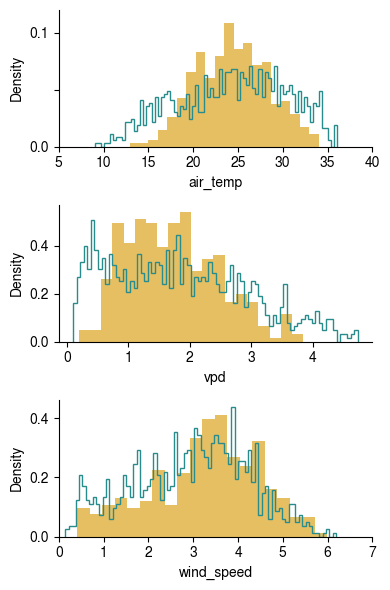

In [19]:

n_cols = 1 
n_rows = -(-len(weather_columns) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4, 6))
# plt.subplots_adjust(hspace=0.5)

marker_heights = [0.12, 0.6, 0.4]

for i, col in enumerate(weather_columns):
    ax = axes.flat[i]
    ax.hist(bombus_visits_df[col], bins=20, color='goldenrod', density=True, alpha=0.7)
    ax.hist(weather_daytime[col], bins= 80, color='#298c8c', density=True, histtype='step')
    
    mean_val = bombus_visits_df[col].mean()
    mean_daytime = weather_daytime[col].mean()
    print(f'{col}, mean_val: {mean_val}, mean_daytime: {mean_daytime}')

    # ax.plot(mean_val, marker_heights[i], marker='|', color='goldenrod', markersize=8)
    # ax.plot(mean_daytime, marker_heights[i], marker='|', color='#298c8c', markersize=8)

    # ax.set_ylabel('Density')


    # ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col, fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_ylabel('Frequency')
    if i == 0:
        ax.set_ylim(0,0.12)
        ax.set_xlim(5, 40)
        ax.set_ylabel('Density')
        ax.set_yticks([0.0, 0.05, 0.1], labels=['0.0', '', '0.1'])

    if i == 1:
        ax.set_ylabel('Density')
    #     ax.set_ylim(0,0.12)
    #     ax.set_xlim(5, 40)

    if i == 2:
        # ax.set_ylim(0,0.12)
        ax.set_ylabel('Density')
        ax.set_xlim(0, 7)


    





# fig.text(0.08, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.savefig('figs/weather_hists.svg', format='svg')

In [20]:
))

SyntaxError: unmatched ')' (840618910.py, line 1)

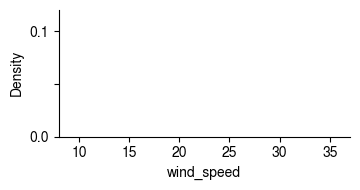

In [ ]:
weather_columns = [col for col in bombus_visits_df.columns if col in ['air_temp']]

n_cols = 1 
n_rows = -(-len(weather_columns) // n_cols)

fig, ax = plt.subplots(1, 1, figsize=(3.7, 2))
# plt.subplots_adjust(hspace=0.5)

marker_heights = [0.12, 0.6, 0.4]


# ax = axes.flat[i]
ax.hist(bombus_visits_df[col], bins=20, color='goldenrod', density=True, alpha=0.7)
ax.hist(weather_daytime[col], bins= 80, color='#298c8c', density=True, histtype='step')

mean_val = bombus_visits_df[col].mean()
mean_daytime = weather_daytime[col].mean()

# ax.plot(mean_val, marker_heights[i], marker='|', color='goldenrod', markersize=8)
# ax.plot(mean_daytime, marker_heights[i], marker='|', color='#298c8c', markersize=8)

# ax.set_ylabel('Density')

ax.set_xlabel(col, fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(0,0.12)
ax.set_xlim(8, 37)
ax.set_ylabel('Density')
ax.set_yticks([0.0, 0.05, 0.1], labels=['0.0', '', '0.1'])

plt.tight_layout()

plt.savefig('figs/airtemp_hist.svg', format='svg')

In [ ]:
import scipy.stats as stats
from scipy.stats import levene

stat, p_value = levene(bombus_visits_df['air_temp'], weather_daytime['air_temp'])
print(f"Levene's Test Statistic: {stat}, P-value: {p_value}")
stats.ttest_ind(bombus_visits_df['air_temp'], weather_daytime['air_temp'], equal_var=False)

Levene's Test Statistic: 87.35619104845921, P-value: 1.4965723626809673e-20


TtestResult(statistic=6.095497656699441, pvalue=2.0963918357884334e-09, df=532.2109137195666)

In [ ]:
stat, p_value = levene(bombus_visits_df['vpd'], weather_daytime['vpd'])
print(f"Levene's Test Statistic: {stat}, P-value: {p_value}")

stats.ttest_ind(bombus_visits_df['vpd'], weather_daytime['vpd'], equal_var=False)

Levene's Test Statistic: 47.770655055269756, P-value: 5.587394281211834e-12


TtestResult(statistic=4.719740866897143, pvalue=3.054559812914551e-06, df=510.08863890060087)

In [ ]:
stat, p_value = levene(bombus_visits_df['wind_speed'].dropna(), weather_daytime['wind_speed'].dropna())
print(f"Levene's Test Statistic: {stat}, P-value: {p_value}")


stats.ttest_ind(bombus_visits_df['wind_speed'].dropna(), weather_daytime['wind_speed'].dropna(), equal_var=False)

Levene's Test Statistic: 8.28769062592977, P-value: 0.004013741775385087


TtestResult(statistic=8.660580598973036, pvalue=8.542153925268879e-17, df=448.5738407248751)

In [ ]:

bombus_times

,filename,pi,datetime,date,time_diff
0,pi1_20240711_084351.jpg,1,2024-07-11 08:43:51,2024-07-11,NaN
1,pi1_20240711_090237.jpg,1,2024-07-11 09:02:37,2024-07-11,1126.0
2,pi1_20240711_095506.jpg,1,2024-07-11 09:55:06,2024-07-11,3149.0
3,pi1_20240711_104047.jpg,1,2024-07-11 10:40:47,2024-07-11,2741.0
4,pi1_20240711_120641.jpg,1,2024-07-11 12:06:41,2024-07-11,5154.0
...,...,...,...,...,...
7651,pi10_20240725_160336.jpg,10,2024-07-25 16:03:36,2024-07-25,4213.0
7652,pi10_20240726_184804.jpg,10,2024-07-26 18:48:04,2024-07-26,NaN
7653,pi10_20240727_160758.jpg,10,2024-07-27 16:07:58,2024-07-27,NaN
7654,pi10_20240809_090208.jpg,10,2024-08-09 09:02:08,2024-08-09,NaN


In [ ]:
weather_daytime.set_index('datetime', inplace=True)
bombus_times.set_index('datetime', inplace=True)
bombus_times['rounded_time'] = bombus_times.index.round('15T')
bee_presence_times = bombus_times['rounded_time'].unique()
weather_daytime['bee_present'] = 0
weather_daytime.loc[bee_presence_times, 'bee_present'] = 1


Text(0.5, 1.0, 'Temperature Over Time with Bee Presence')

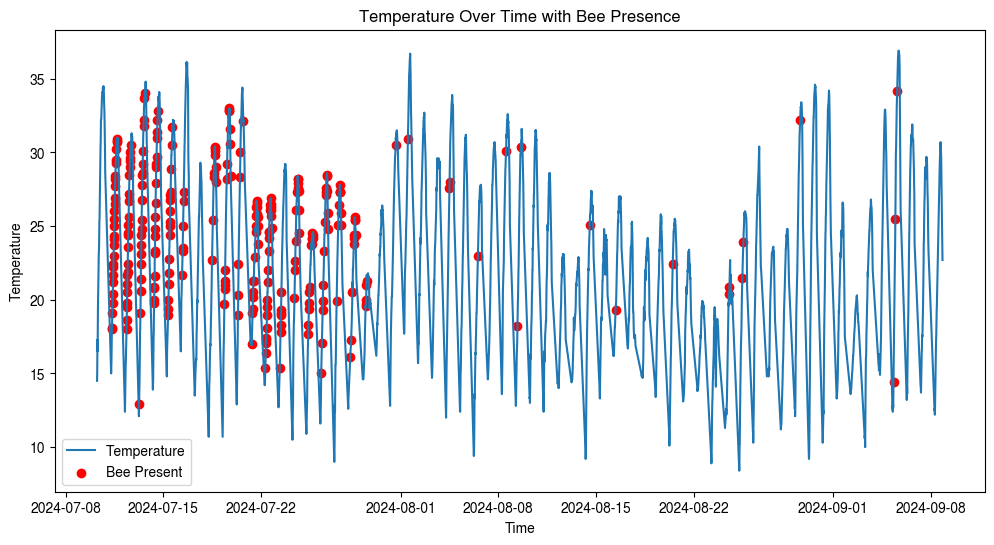

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(weather_daytime.index, weather_daytime['air_temp'], label='Temperature')
plt.scatter(weather_daytime[weather_daytime['bee_present'] == 1].index,
            weather_daytime[weather_daytime['bee_present'] == 1]['air_temp'],
            color='red', label='Bee Present')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time with Bee Presence')

Text(0.5, 1.0, 'Autocorrelation of Temperature')

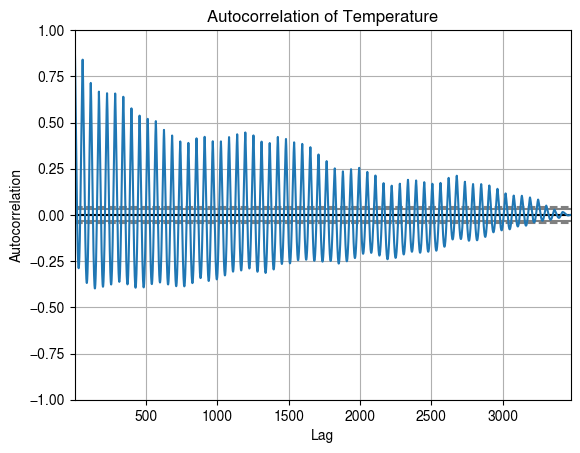

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(weather_daytime['air_temp'])
plt.title('Autocorrelation of Temperature')

In [ ]:
weather_columns

['air_temp']

In [ ]:
import statsmodels.api as sm

weather_daytime.reset_index(inplace=True)

X = weather_daytime[['air_temp',
 'vapor_pres',
 'atm_pres',
 'vpd',
 'wind_dir',
 'wind_speed',
 'gust_sp',
 'ppfd']].dropna()

# Add a constant term for the intercept
X = sm.add_constant(X)

y = weather_daytime['bee_present']

model = sm.Logit(y, X).fit()
print(model.summary())

ValueError: The indices for endog and exog are not aligned

In [ ]:
weather_with_bees = weather_daytime[weather_daytime['bee_present'] == 1]
weather_without_bees = weather_daytime[weather_daytime['bee_present'] == 0]

from scipy.stats import shapiro


for var in weather_columns:
    stat, p = shapiro(weather_daytime[var])
    print(f'Shapiro-Wilk test for {var}: Statistics={stat}, p={p}')

from scipy.stats import ttest_ind, mannwhitneyu

results = []

for var in weather_columns:
    data_with_bees = weather_with_bees[var].dropna()
    data_without_bees = weather_without_bees[var].dropna()
    
    # Check normality for both groups
    _, p_normal_with = shapiro(data_with_bees)
    _, p_normal_without = shapiro(data_without_bees)
    
    if p_normal_with > 0.05 and p_normal_without > 0.05:
        # Use t-test
        stat, p_value = ttest_ind(data_with_bees, data_without_bees)
        test = 't-test'
    else:
        # Use Mann-Whitney U test
        stat, p_value = mannwhitneyu(data_with_bees, data_without_bees)
        test = 'Mann-Whitney U'
    
    results.append({
        'Variable': var,
        'Test': test,
        'Statistic': stat,
        'p-value': p_value
    })

results_df = pd.DataFrame(results)
print(results_df)


Shapiro-Wilk test for air_temp: Statistics=0.9871818423271179, p=3.229495422014027e-17
Shapiro-Wilk test for vapor_pres: Statistics=0.997846782207489, p=9.567738743498921e-05
Shapiro-Wilk test for atm_pres: Statistics=0.9941339492797852, p=1.231220125852417e-10
Shapiro-Wilk test for vpd: Statistics=0.9417217969894409, p=5.529244180061057e-35
Shapiro-Wilk test for wind_dir: Statistics=nan, p=1.0
Shapiro-Wilk test for wind_speed: Statistics=nan, p=1.0
Shapiro-Wilk test for gust_sp: Statistics=nan, p=1.0
Shapiro-Wilk test for ppfd: Statistics=0.9353803992271423, p=1.9443802264893385e-36
     Variable            Test  Statistic       p-value
0    air_temp  Mann-Whitney U   491738.0  1.012189e-05
1  vapor_pres  Mann-Whitney U   366028.5  2.981754e-04
2    atm_pres  Mann-Whitney U   516989.5  1.659301e-09
3         vpd  Mann-Whitney U   506528.0  8.347735e-08
4    wind_dir  Mann-Whitney U   452766.0  2.872037e-02
5  wind_speed  Mann-Whitney U   551279.0  1.386250e-17
6     gust_sp  Mann-Whit

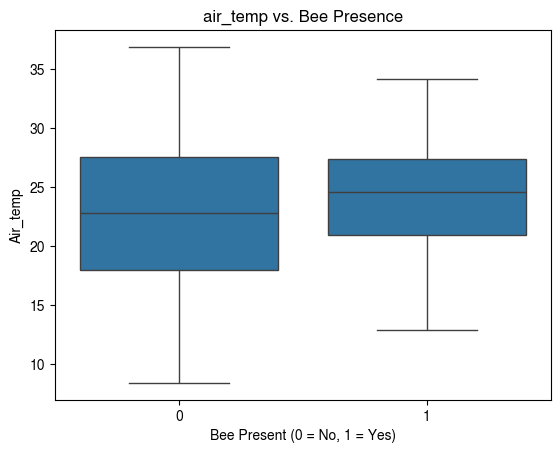

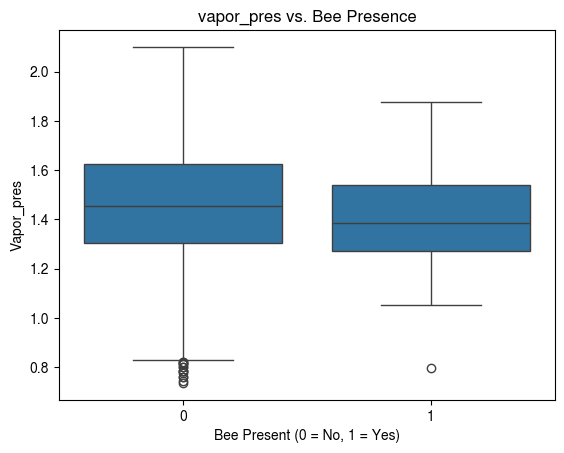

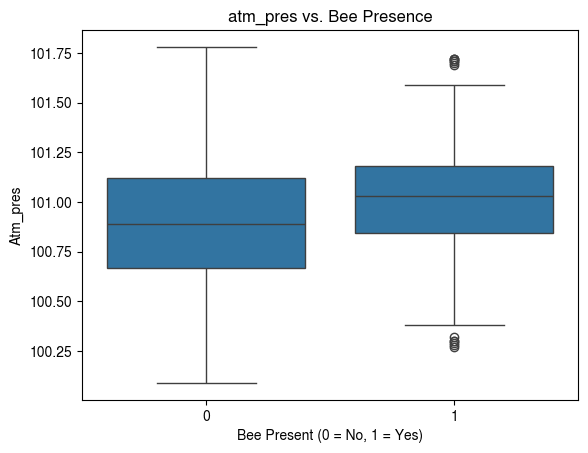

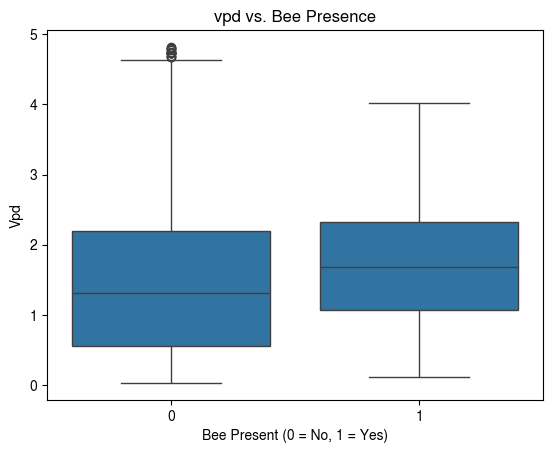

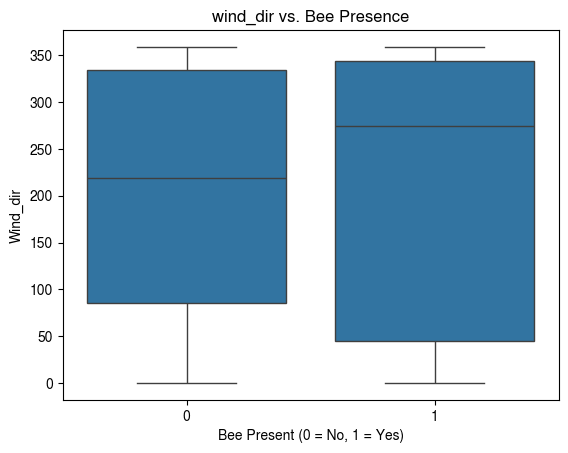

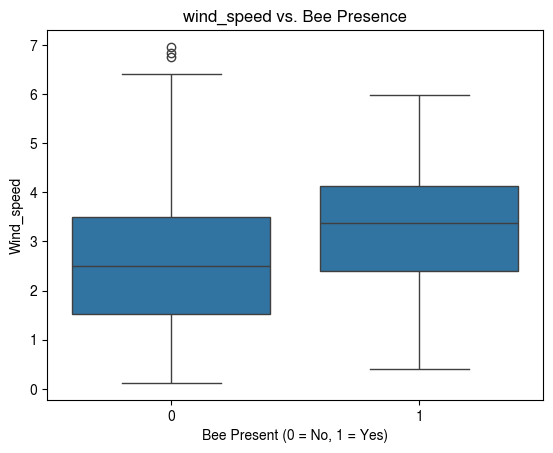

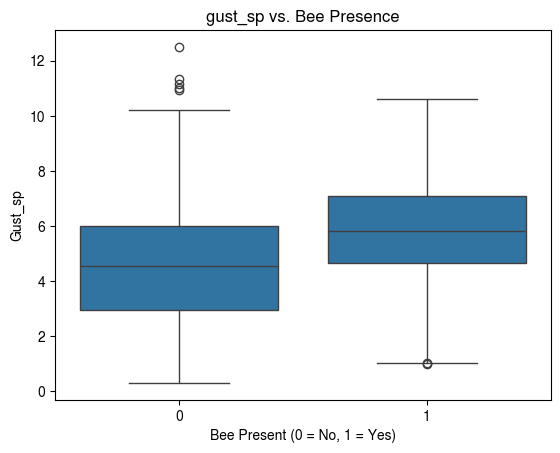

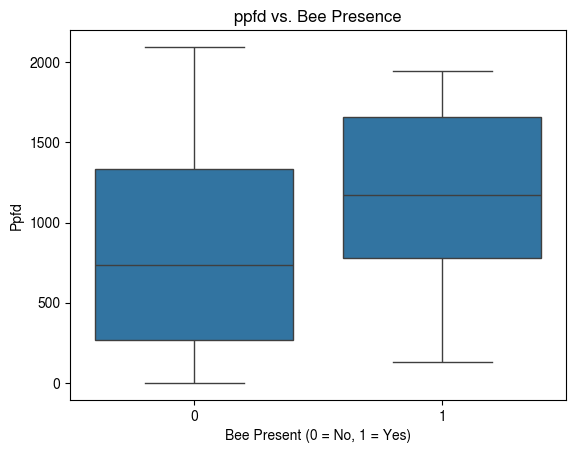

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for var in weather_columns:
    sns.boxplot(x='bee_present', y=var, data=weather_daytime)
    plt.title(f'{var} vs. Bee Presence')
    plt.xlabel('Bee Present (0 = No, 1 = Yes)')
    plt.ylabel(var.capitalize())
    plt.show()